# Desertification Index from Satellite Data

In [2]:
# APPEEARS API user and password
%run "dataLogin.ipynb"

import pandas as pd
import matplotlib.pyplot as plt
import climateservaccess as ca
import json
#import ipywidgets as widgets
#import pyperclip
import geopandas as gpd
from shapely.geometry import Polygon
import folium
import datetime
import numpy as np
import os
import requests
import time
import rasterio
#import rasterio.plot
import calendar
import branca.colormap as cm
import re
from bs4 import BeautifulSoup

## Definitions

First we define the latitude, longitude and angular resolution of the region of interest, and the start and end year of analysis.

In [3]:
_posMaps = [-8.708053542826518, -41.29821986351566] # center of area of interest in latitude and longitude
_res = 15 # area of interest size in decimal degrees (climateserv)
_ano_inicial = 2000  # start year
_ano_final = 2010   # end year

This gets the name of the center of the region of interest.

In [4]:
def get_location_name(latitude, longitude):
  """Get geographical location name by latitude and longitude from Nominatim"""
  
  # construir a url da API do Nominatim
  url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}"
  # fazer uma requisição GET e obter a resposta em formato JSON
  response = requests.get(url).json()
  # extrair o nome do local do campo display_name
  location_name = response["address"]
  # retornar o nome do local
  return f"{location_name['town']} - {location_name['state']} - {location_name['country']}" #f"{location_name['city_district']} - {location_name['town']} - {location_name['state']} - {location_name['region']} - {location_name['country']}" 

_NomeLocal = get_location_name(_posMaps[0], _posMaps[1])
print(f"Region Name: {_NomeLocal}")

Region Name: Afrânio - Pernambuco - Brasil


Then we define auxiliary variables and create cache directories.

In [5]:
# Variables for APPEEARS API
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  
user = _usuario # APPEARS username
password = _senha # APPEARS password
inDir = 'cache_data'  # cache directory name

# Create directories 
if not os.path.exists(inDir):
    os.makedirs(inDir)
_localdataName = f"{inDir}/{_posMaps[0]} {_posMaps[1]} {_res}"
if not os.path.exists(_localdataName):
    os.makedirs(_localdataName)
_graficos = _localdataName + "/resultados/"
if not os.path.exists(_graficos):
    os.makedirs(_graficos)

## Creating Area of Interest

We use the site [Geojson.io](https://geojson.io/) to mark the geographical area to be analyzed.

In [6]:
link = "https://geojson.io/#map=8/"+str(round(_posMaps[0],3))+"/"+str(round(_posMaps[1],3))
print(link)

https://geojson.io/#map=8/-8.708/-41.298


Next, we create a GEOJson from input geographical coordinates.


In [7]:
# dynamically get the world-country boundaries 
res = requests.get("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json")
df = pd.DataFrame(json.loads(res.content.decode()))
df = df.assign(id=df["features"].apply(pd.Series)["id"],
         name=df["features"].apply(pd.Series)["properties"].apply(pd.Series)["name"])


# create the base map
m = folium.Map(location = _posMaps,
               zoom_start=4,
               control_scale=True)

# a list of interesting countries
countries = ["Brazil"]

# overlay desired countries over folium map
for r in df.loc[df["name"].isin(countries)].to_dict(orient="records"):
    folium.GeoJson(r["features"], name=r["name"], tooltip=r["name"]).add_to(m)

m

In [8]:
_quadrado = ca.getBox(_posMaps[0], _posMaps[1], _res)  
# data_Json = {
#    "type": "FeatureCollection",
#    "features": [df[df.name == 'Brazil'].features[22] ] }
data_Json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            _quadrado[0],
            _quadrado[1],
            _quadrado[2],
            _quadrado[3],
            _quadrado[0]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
json_string = json.dumps(data_Json, indent=2)
# print(json_string)
# button = widgets.Button(description="Copiar GeJson")
# def on_button_clicked(b):
#     pyperclip.copy(json_string)
# button.on_click(on_button_clicked)
# button

# Polygon of Brazil
_polyBR = [[-56.2909, -28.852761],
    [-55.162286, -27.881915],
    [-54.490725, -27.474757],
    [-53.648735, -26.923473],
    [-53.628349, -26.124865],
    [-54.13005, -25.547639],
    [-54.625291, -25.739255],
    [-54.428946, -25.162185],
    [-54.293476, -24.5708],
    [-54.29296, -24.021014],
    [-54.652834, -23.839578],
    [-55.027902, -24.001274],
    [-55.400747, -23.956935],
    [-55.517639, -23.571998],
    [-55.610683, -22.655619],
    [-55.797958, -22.35693],
    [-56.473317, -22.0863],
    [-56.88151, -22.282154],
    [-57.937156, -22.090176],
    [-57.870674, -20.732688],
    [-58.166392, -20.176701],
    [-57.853802, -19.969995],
    [-57.949997, -19.400004],
    [-57.676009, -18.96184],
    [-57.498371, -18.174188],
    [-57.734558, -17.552468],
    [-58.280804, -17.27171],
    [-58.388058, -16.877109],
    [-58.24122, -16.299573],
    [-60.15839, -16.258284],
    [-60.542966, -15.09391],
    [-60.251149, -15.077219],
    [-60.264326, -14.645979],
    [-60.459198, -14.354007],
    [-60.503304, -13.775955],
    [-61.084121, -13.479384],
    [-61.713204, -13.489202],
    [-62.127081, -13.198781],
    [-62.80306, -13.000653],
    [-63.196499, -12.627033],
    [-64.316353, -12.461978],
    [-65.402281, -11.56627],
    [-65.321899, -10.895872],
    [-65.444837, -10.511451],
    [-65.338435, -9.761988],
    [-66.646908, -9.931331],
    [-67.173801, -10.306812],
    [-68.048192, -10.712059],
    [-68.271254, -11.014521],
    [-68.786158, -11.03638],
    [-69.529678, -10.951734],
    [-70.093752, -11.123972],
    [-70.548686, -11.009147],
    [-70.481894, -9.490118],
    [-71.302412, -10.079436],
    [-72.184891, -10.053598],
    [-72.563033, -9.520194],
    [-73.226713, -9.462213],
    [-73.015383, -9.032833],
    [-73.571059, -8.424447],
    [-73.987235, -7.52383],
    [-73.723401, -7.340999],
    [-73.724487, -6.918595],
    [-73.120027, -6.629931],
    [-73.219711, -6.089189],
    [-72.964507, -5.741251],
    [-72.891928, -5.274561],
    [-71.748406, -4.593983],
    [-70.928843, -4.401591],
    [-70.794769, -4.251265],
    [-69.893635, -4.298187],
    [-69.444102, -1.556287],
    [-69.420486, -1.122619],
    [-69.577065, -0.549992],
    [-70.020656, -0.185156],
    [-70.015566, 0.541414],
    [-69.452396, 0.706159],
    [-69.252434, 0.602651],
    [-69.218638, 0.985677],
    [-69.804597, 1.089081],
    [-69.816973, 1.714805],
    [-67.868565, 1.692455],
    [-67.53781, 2.037163],
    [-67.259998, 1.719999],
    [-67.065048, 1.130112],
    [-66.876326, 1.253361],
    [-66.325765, 0.724452],
    [-65.548267, 0.789254],
    [-65.354713, 1.095282],
    [-64.611012, 1.328731],
    [-64.199306, 1.492855],
    [-64.083085, 1.916369],
    [-63.368788, 2.2009],
    [-63.422867, 2.411068],
    [-64.269999, 2.497006],
    [-64.408828, 3.126786],
    [-64.368494, 3.79721],
    [-64.816064, 4.056445],
    [-64.628659, 4.148481],
    [-63.888343, 4.02053],
    [-63.093198, 3.770571],
    [-62.804533, 4.006965],
    [-62.08543, 4.162124],
    [-60.966893, 4.536468],
    [-60.601179, 4.918098],
    [-60.733574, 5.200277],
    [-60.213683, 5.244486],
    [-59.980959, 5.014061],
    [-60.111002, 4.574967],
    [-59.767406, 4.423503],
    [-59.53804, 3.958803],
    [-59.815413, 3.606499],
    [-59.974525, 2.755233],
    [-59.718546, 2.24963],
    [-59.646044, 1.786894],
    [-59.030862, 1.317698],
    [-58.540013, 1.268088],
    [-58.429477, 1.463942],
    [-58.11345, 1.507195],
    [-57.660971, 1.682585],
    [-57.335823, 1.948538],
    [-56.782704, 1.863711],
    [-56.539386, 1.899523],
    [-55.995698, 1.817667],
    [-55.9056, 2.021996],
    [-56.073342, 2.220795],
    [-55.973322, 2.510364],
    [-55.569755, 2.421506],
    [-55.097587, 2.523748],
    [-54.524754, 2.311849],
    [-54.088063, 2.105557],
    [-53.778521, 2.376703],
    [-53.554839, 2.334897],
    [-53.418465, 2.053389],
    [-52.939657, 2.124858],
    [-52.556425, 2.504705],
    [-52.249338, 3.241094],
    [-51.657797, 4.156232],
    [-51.317146, 4.203491],
    [-51.069771, 3.650398],
    [-50.508875, 1.901564],
    [-49.974076, 1.736483],
    [-49.947101, 1.04619],
    [-50.699251, 0.222984],
    [-50.388211, -0.078445],
    [-48.620567, -0.235489],
    [-48.584497, -1.237805],
    [-47.824956, -0.581618],
    [-46.566584, -0.941028],
    [-44.905703, -1.55174],
    [-44.417619, -2.13775],
    [-44.581589, -2.691308],
    [-43.418791, -2.38311],
    [-41.472657, -2.912018],
    [-39.978665, -2.873054],
    [-38.500383, -3.700652],
    [-37.223252, -4.820946],
    [-36.452937, -5.109404],
    [-35.597796, -5.149504],
    [-35.235389, -5.464937],
    [-34.89603, -6.738193],
    [-34.729993, -7.343221],
    [-35.128212, -8.996401],
    [-35.636967, -9.649282],
    [-37.046519, -11.040721],
    [-37.683612, -12.171195],
    [-38.423877, -13.038119],
    [-38.673887, -13.057652],
    [-38.953276, -13.79337],
    [-38.882298, -15.667054],
    [-39.161092, -17.208407],
    [-39.267339, -17.867746],
    [-39.583521, -18.262296],
    [-39.760823, -19.599113],
    [-40.774741, -20.904512],
    [-40.944756, -21.937317],
    [-41.754164, -22.370676],
    [-41.988284, -22.97007],
    [-43.074704, -22.967693],
    [-44.647812, -23.351959],
    [-45.352136, -23.796842],
    [-46.472093, -24.088969],
    [-47.648972, -24.885199],
    [-48.495458, -25.877025],
    [-48.641005, -26.623698],
    [-48.474736, -27.175912],
    [-48.66152, -28.186135],
    [-48.888457, -28.674115],
    [-49.587329, -29.224469],
    [-50.696874, -30.984465],
    [-51.576226, -31.777698],
    [-52.256081, -32.24537],
    [-52.7121, -33.196578],
    [-53.373662, -33.768378],
    [-53.650544, -33.202004],
    [-53.209589, -32.727666],
    [-53.787952, -32.047243],
    [-54.572452, -31.494511],
    [-55.60151, -30.853879],
    [-55.973245, -30.883076],
    [-56.976026, -30.109686],
    [-57.625133, -30.216295]]

This GEOJson can now be used to draw the area of interest in map generated by the `folium` package.

In [9]:
quadrado = Polygon(_quadrado)
quadrado_gdf = gpd.GeoSeries(quadrado)
geo_json_data = quadrado_gdf.to_json()
#geo_json_data = gpd.GeoSeries(Polygon(_polyBR)).to_json()
mapa = folium.Map(location=[_posMaps[0],_posMaps[1]])
#quadrado_gdf.add_to(mapa)
folium.GeoJson(geo_json_data).add_to(mapa)
# obter os limites do polígono
bounds = folium.GeoJson(geo_json_data).get_bounds()
# ajustar o mapa para os limites
zoom = mapa.fit_bounds(bounds)
mapa.save(_graficos+"map.html")
mapa

## Precipitation Data

In [10]:
# def dias_mes(mes, ano):
#   """"""
#   data = datetime.date(ano, mes, 1)
#   proximo_mes = data.replace(month=data.month % 12 + 1)
#   ultimo_dia = proximo_mes - datetime.timedelta(days=1)
#   return ultimo_dia.day

def precipitacao_mes(mes, ano):
    """ Collects monthly precipitation data from month "mes" and year "ano" and returns a Pandas dataframe. """

    ultimodia = calendar.monthrange(ano,mes) #dias_mes(mes, ano)
    data_type = 26  # code for precipitation data
    start_date = "{:02d}/01/{}".format(mes, ano) 
    end_date = "{:02d}/{:02d}/{}".format(mes,ultimodia, ano+1)
    operation_type = 'average'
    polygon = _quadrado
    df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
    data_df = pd.DataFrame(df['data'].to_list())
    valores = data_df["raw_value"].mean()
    return valores

def precipitacao_ano(ano):
    """ Collects yearly precipitation data from year "ano" and returns a Pandas dataframe. """

    #_localdataName
    arqName = f"{_localdataName}/{ano} precipit data.csv"
    data_type = 26 #dados de precipitação
    start_date = "01/01/{}".format(ano) 
    end_date = "12/31/{}".format(ano)
    operation_type = 'average'
    polygon = _quadrado
    if os.path.exists(arqName): 
        print(f"Arquivo do ano de {ano} já baixado, carregando arquivos locais ...")
        df = pd.read_csv(arqName+".raw")
        return df['raw_value']
    else:
        df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
        df.to_csv(arqName)
        data_df = pd.DataFrame(df['data'].to_list())
        data_df['raw_value'].to_csv(arqName+".raw")
        return data_df['raw_value']

# def downloadinfo(file_url, name):
#     response = requests.get(file_url, stream=True)
#     file_size = int(response.headers.get("content-length", 0))
#     progress = tqdm.tqdm(total=file_size, unit="B", unit_scale=True)
#     with open(name, "wb") as f:
#         for chunk in response.iter_content(chunk_size=1024):
#             f.write(chunk)
#             progress.update(len(chunk))
#     progress.close()

In [11]:
# Fills a dictionary "_precipitacao" with yearly precipitation data
_precipitacao = {}
for i in range(_ano_inicial,_ano_final+1):
    _precipitacao[i] = precipitacao_ano(i)

# Generate a Pandas DataFrame with Yearly Precipitation Data
_dados = pd.DataFrame()
_dados["Ano"] = []
_dados["Precipitacao"] = []
for i in range(_ano_inicial, _ano_final+1):
    total = _precipitacao[i].sum()
    _dados.loc[len(_dados.index)] = [i, total]
_dados["Ano"] = _dados["Ano"].astype(int)

# This probably can be done by a simple pandas manipulation
#_dados = pd.DataFrame(pd.DataFrame(_precipitacao).sum())

#_dados.head()

Arquivo do ano de 2000 já baixado, carregando arquivos locais ...
Arquivo do ano de 2001 já baixado, carregando arquivos locais ...
Arquivo do ano de 2002 já baixado, carregando arquivos locais ...
Arquivo do ano de 2003 já baixado, carregando arquivos locais ...
Arquivo do ano de 2004 já baixado, carregando arquivos locais ...
Arquivo do ano de 2005 já baixado, carregando arquivos locais ...
Arquivo do ano de 2006 já baixado, carregando arquivos locais ...
Arquivo do ano de 2007 já baixado, carregando arquivos locais ...
Arquivo do ano de 2008 já baixado, carregando arquivos locais ...
Arquivo do ano de 2009 já baixado, carregando arquivos locais ...
Arquivo do ano de 2010 já baixado, carregando arquivos locais ...


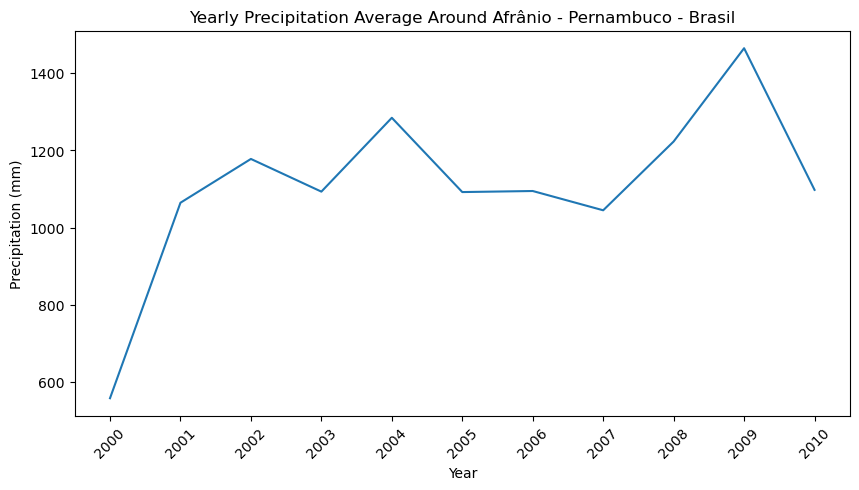

In [12]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"])
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)], rotation=45)
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title(f'Yearly Precipitation Average Around {_NomeLocal}')
plt.savefig(_graficos+"precipitacao.png", format="png")
plt.savefig(_graficos+"precipitacao.pdf", format="pdf")
plt.show()

## Evapotranspiration Data

Here we download and plot the evapotranspiration data from MODIS satellite (product `MOD16A3GF.061`) in the area of interest using the AppEEars API.

In [13]:
token_response = requests.post('{}login'.format(api), auth=(user, password)).json()
token = token_response['token']                 
head = {'Authorization': 'Bearer {}'.format(token)}
print(token_response, token)

{'token_type': 'Bearer', 'token': 'L8_brMSafkS48wbkyUCI3w7Q_HUEOuqx7DvOZ3FB_2WZBV3P53ym0Ns386iT6pG8sC4Jznr9VziDuaMTBICUmw', 'expiration': '2024-01-28T22:33:20Z'} L8_brMSafkS48wbkyUCI3w7Q_HUEOuqx7DvOZ3FB_2WZBV3P53ym0Ns386iT6pG8sC4Jznr9VziDuaMTBICUmw


In [14]:
produto_usado = "MOD16A3GF.061"
lst_response = requests.get('{}product/{}'.format(api, produto_usado)).json()
list(lst_response.keys())

['ET_500m', 'ET_QC_500m', 'LE_500m', 'PET_500m', 'PLE_500m']

In [15]:
projections = requests.get('{}spatial/proj'.format(api)).json() 
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p
projs.keys() 

dict_keys(['native', 'geographic', 'sinu_modis', 'albers_weld_alaska', 'albers_weld_conus', 'albers_ard_alaska', 'albers_ard_conus', 'albers_ard_hawaii', 'easegrid_2_global', 'easegrid_2_north'])

In [16]:
prodLayer = []
bandas_usadas = ['ET_500m',  'PET_500m']
for l in lst_response.keys():
    if l in bandas_usadas:
        prodLayer.append({
                "layer": l,
                "product": produto_usado
              })
prodLayer

[{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
 {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}]

In [17]:
# Task configuration
task_type = ['point','area']        # Type of task, area or point
proj = projs['geographic']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
recurring = True                   # Specify True for a recurring date range
yearRange = [_ano_inicial, _ano_final]
task_name = _NomeLocal+" "+str(_ano_inicial)
task = {
        'task_type': task_type[1],
        'task_name': task_name,
        'params': {
             'dates': [
             {
                 'startDate': '01-01',
                 'endDate': '12-31',
                 'yearRange': yearRange,
                 'recurring': recurring
             }],
             'layers': prodLayer,
             'output': {
                     'format': {
                             'type': outFormat[0]}, 
                             'projection': proj},
             'geo': data_Json,
        }
    }
task

{'task_type': 'area',
 'task_name': 'Afrânio - Pernambuco - Brasil 2000',
 'params': {'dates': [{'startDate': '01-01',
    'endDate': '12-31',
    'yearRange': [2000, 2010],
    'recurring': True}],
  'layers': [{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
   {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}],
  'output': {'format': {'type': 'geotiff'}, 'projection': 'geographic'},
  'geo': {'type': 'FeatureCollection',
   'features': [{'type': 'Feature',
     'properties': {},
     'geometry': {'coordinates': [[[-48.79821986351566, -1.2080535428265176],
        [-33.79821986351566, -1.2080535428265176],
        [-33.79821986351566, -16.20805354282652],
        [-48.79821986351566, -16.20805354282652],
        [-48.79821986351566, -1.2080535428265176]]],
      'type': 'Polygon'}}]}}}

In [18]:
task_response = ""
_appEEARsDir = _localdataName+"/"+task_name
if not os.path.exists(_appEEARsDir):
    os.makedirs(_appEEARsDir)
    task_response = requests.post('{}task'.format(api), json=task, headers=head).json()
print(task_response)

{'task_id': '88298700-5653-4307-b4b9-bae1479f8e01', 'status': 'pending'}


In [19]:
def status(id_tarefa):
    return requests.get('{}task/{}'.format(api, id_tarefa), headers=head).json()['status']
if task_response != "":
    task_id = task_response['task_id']                                               
    status_response = requests.get('{}status/{}'.format(api, task_id), headers=head).json() 
    print(status_response)
    starttime = time.time()
    intervalo = 20.0
    _status = status(task_id)
    while _status != 'done':
        _status = status(task_id)
        time.sleep(intervalo - ((time.time() - starttime) % intervalo))
        print(_status)
    print(_status)
else:
    print("Os dados já haviam sido baixados")

{'task_id': '88298700-5653-4307-b4b9-bae1479f8e01', 'status': 'queued', 'user_id': 'fabio.nsantos@gmail.com', 'updated': '2024-01-26T23:20:59.310831', 'status_type': 'task'}
queued
queued
queued
queued
queued
queued
queued
queued
queued
queued
queued
queued
processing
processing
processing
processing
processing
processing
processing
processing
processing
processing
done
done


In [20]:
if task_response != "":
    bundle = requests.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
    files = {}                                                       # Create empty dictionary
    for f in bundle['files']: files[f['file_id']] = f['file_name']
    cont = 0
    numero = len(files)
    for f in files:
        if files[f].endswith('.tif'):
            filename = files[f].split('/')[1]
        else:
            filename = files[f] 
        if os.path.exists(_appEEARsDir +"/"+filename):
            cont += 1
        else:
            dl = requests.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')
            filepath = os.path.join(_appEEARsDir, filename)                                                      
            with open(filepath, 'wb') as f:                                                                
                for data in dl.iter_content(chunk_size=8192): f.write(data)
            cont += 1
        print(f"Baixando arquivos {cont} / {numero}")
    print('Todos os arquivos da tarefa salvos em: {}'.format(_appEEARsDir))

Baixando arquivos 1 / 39
Baixando arquivos 2 / 39
Baixando arquivos 3 / 39
Baixando arquivos 4 / 39
Baixando arquivos 5 / 39
Baixando arquivos 6 / 39
Baixando arquivos 7 / 39
Baixando arquivos 8 / 39
Baixando arquivos 9 / 39
Baixando arquivos 10 / 39
Baixando arquivos 11 / 39
Baixando arquivos 12 / 39
Baixando arquivos 13 / 39
Baixando arquivos 14 / 39
Baixando arquivos 15 / 39
Baixando arquivos 16 / 39
Baixando arquivos 17 / 39
Baixando arquivos 18 / 39
Baixando arquivos 19 / 39
Baixando arquivos 20 / 39
Baixando arquivos 21 / 39
Baixando arquivos 22 / 39
Baixando arquivos 23 / 39
Baixando arquivos 24 / 39
Baixando arquivos 25 / 39
Baixando arquivos 26 / 39
Baixando arquivos 27 / 39
Baixando arquivos 28 / 39
Baixando arquivos 29 / 39
Baixando arquivos 30 / 39
Baixando arquivos 31 / 39
Baixando arquivos 32 / 39
Baixando arquivos 33 / 39
Baixando arquivos 34 / 39
Baixando arquivos 35 / 39
Baixando arquivos 36 / 39
Baixando arquivos 37 / 39
Baixando arquivos 38 / 39
Baixando arquivos 39 

In [21]:
if os.path.exists(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv"):
    _dataEvapo = pd.read_csv(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv")
_dataEvapo.head()

,File Name,Dataset,aid,Date,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
0,MOD16A3GF_061_ET_500m_doy2000049_aid0001,ET_500m,aid0001,2000-02-18,9312912,183.0,2770.3,"(183.0,2770.3)",1046.703950,343.641230,118089.294857,1286.8,2050.0,1008.8,183.0,778.0
1,MOD16A3GF_061_ET_500m_doy2001001_aid0001,ET_500m,aid0001,2001-01-01,9312912,97.5,2841.9,"(97.5,2841.9)",866.462990,377.803943,142735.819638,1098.3,1877.1,781.9,97.5,579.1
2,MOD16A3GF_061_ET_500m_doy2002001_aid0001,ET_500m,aid0001,2002-01-01,9312912,142.6,2680.7,"(142.6,2680.7)",891.964856,363.162318,131886.868984,1116.1,1871.2,806.1,142.6,612.7
3,MOD16A3GF_061_ET_500m_doy2003001_aid0001,ET_500m,aid0001,2003-01-01,9312912,128.4,3006.7,"(128.4,3006.7)",906.869971,365.497180,133588.188907,1120.7,1844.3,838.4,128.4,638.3
4,MOD16A3GF_061_ET_500m_doy2004001_aid0001,ET_500m,aid0001,2004-01-01,9312912,183.0,3221.2,"(183.0,3221.2)",1004.439675,310.192859,96219.609791,1185.5,1793.0,951.5,183.0,780.5


In [22]:
mean_1, mean_2 = np.array_split(_dataEvapo["Mean"], 2)
nova_tabela1 = pd.DataFrame({"ET": mean_1})
nova_tabela2 = pd.DataFrame( {"PET": mean_2.to_list()})
_dados["ET"] = nova_tabela1["ET"]
_dados["PET"] = nova_tabela2["PET"]
#remover linhas invalidas
_dados.dropna(inplace=True)
_dados.head()

,Ano,Precipitacao,ET,PET
0,2000,557.394307,1046.703950,2376.655382
1,2001,1064.389200,866.462990,2455.659074
2,2002,1177.970682,891.964856,2477.108651
3,2003,1093.212461,906.869971,2432.468774
4,2004,1284.734732,1004.439675,2401.399219


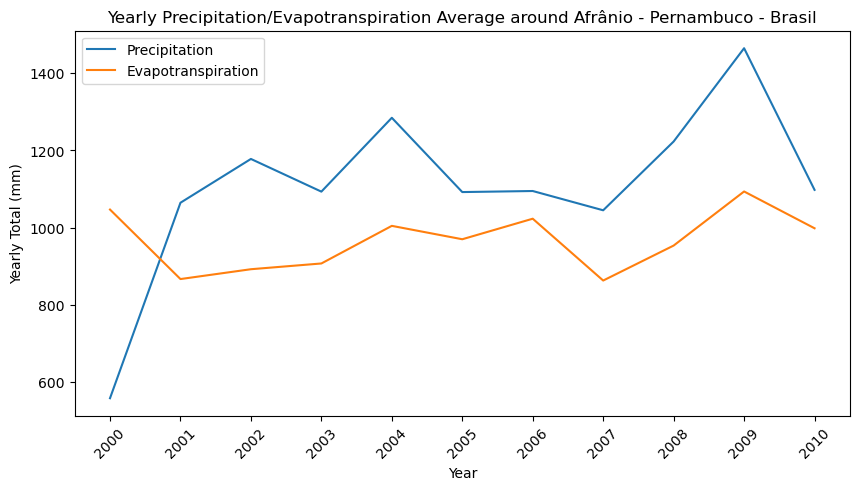

In [23]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"], label="Precipitation")
plt.plot(_dados["Ano"], _dados["ET"], label="Evapotranspiration")
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)],  rotation=45)
plt.xlabel('Year')
plt.ylabel('Yearly Total (mm)')
plt.title(f'Yearly Precipitation/Evapotranspiration Average around {_NomeLocal}')
plt.legend()
plt.savefig(_graficos+"precipitacao e evaporacao.png", format="png")
plt.savefig(_graficos+"precipitacao.pdf", format="pdf")
plt.show()

In [24]:
_dados['Indice de Aridez UNEP'] = _dados["Precipitacao"] / _dados["PET"]
_dados['Aridez'] = _dados["Precipitacao"] / _dados["ET"]
_dados.head()

,Ano,Precipitacao,ET,PET,Indice de Aridez UNEP,Aridez
0,2000,557.394307,1046.703950,2376.655382,0.234529,0.532523
1,2001,1064.389200,866.462990,2455.659074,0.433443,1.228430
2,2002,1177.970682,891.964856,2477.108651,0.475543,1.320647
3,2003,1093.212461,906.869971,2432.468774,0.449425,1.205479
4,2004,1284.734732,1004.439675,2401.399219,0.534994,1.279056


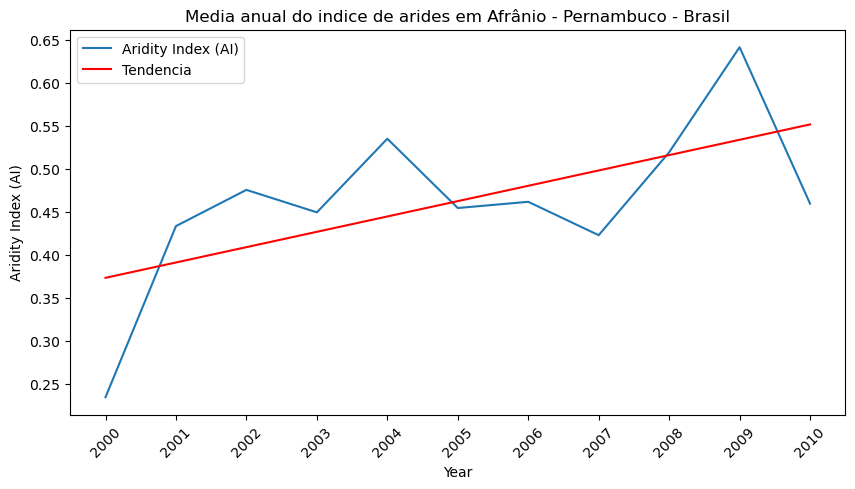

In [25]:
z = np.polyfit(_dados["Ano"], _dados["Indice de Aridez UNEP"], 1)
p = np.poly1d(z) # Criando um objeto polinomial
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Indice de Aridez UNEP"],label="Aridity Index (AI)")
plt.plot(_dados["Ano"], p(_dados["Ano"]), 'r-',label="Tendencia")
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)], rotation=45)
plt.xlabel('Year')
plt.ylabel('Aridity Index (AI)')
plt.title(f'Media anual do indice de arides em {_NomeLocal}')
plt.legend()
plt.savefig(_graficos+"IA.png", format="png")
plt.savefig(_graficos+"precipitacao.pdf", format="pdf")
plt.show()

## Computing the Aridity Index (AI)

An aridity index (AI) is a numerical indicator of the degree of dryness of the climate at a given location. The American Meteorological Society defined it in meteorology and climatology, as "the degree to which a climate lacks effective, life-promoting moisture". Aridity is different from drought because aridity is permanent whereas drought is temporary.[1] A number of aridity indices have been proposed (see below); these indicators serve to identify, locate or delimit regions that suffer from a deficit of available water, a condition that can severely affect the effective use of the land for such activities as agriculture or stock-farming.

In [26]:
def categoria_climatica(indice):
    if indice >= 0.65:
        return 'Úmida'
    elif indice >= 0.5:
        return 'Subúmida'
    elif indice >= 0.2:
        return 'Semiárida'
    elif indice >= 0.05:
        return 'Árida'
    else:
        return 'Hiperárida'
def risco_desertificacao(ai):
  if ai < 0.05:
    return "Acima de Muito Alto (MMA)"
  elif 0.05 <= ai <= 0.20:
    return "Muito Alto (MA)"
  elif 0.21 <= ai <= 0.50:
    return "Alto (A)"
  elif 0.51 <= ai <= 0.65:
    return "Moderado (M)"
  else:
    return "Baixo (B)"
_IndiceAridez = _dados['Indice de Aridez UNEP'].mean()
_Aridez = _dados['Indice de Aridez UNEP'].mean()
_AriderN = (p(_dados["Ano"])).mean()
aridez = _dados.iloc[-1]['Indice de Aridez UNEP']
print(f"Essa região está classificada atualmente como sendo uma região {aridez:.2f}, o que lhe classifica como uma região {categoria_climatica(aridez)}")
print(f"Entre os anos de {_ano_inicial } e {_ano_final}, a região teve um indice medio de {_AriderN:.2f}, o que lhe classifica como uma região {categoria_climatica(_AriderN)}")
print(f"A chance de desertificação da região está classificada como {risco_desertificacao(_AriderN)}")
#if a < 0:
#    print("Foi observado um processo de diminuição do total de chuva em relação ao total de evaporação")

Essa região está classificada atualmente como sendo uma região 0.46, o que lhe classifica como uma região Semiárida
Entre os anos de 2000 e 2010, a região teve um indice medio de 0.46, o que lhe classifica como uma região Semiárida
A chance de desertificação da região está classificada como Alto (A)


In [27]:
_dados["Aridez2"] = _dados["ET"] / _dados["PET"]
_Aridez2 = _dados['Aridez2'].mean()
print(f"Comparando os 2 indices para verificar equivalencia {_Aridez:.2f} ~= {_Aridez2:.2f}")

Comparando os 2 indices para verificar equivalencia 0.46 ~= 0.40


In [28]:
nomes = os.listdir(_appEEARsDir) 
_arquivos = [nome for nome in nomes if os.path.isfile(os.path.join(_appEEARsDir, nome))] 

_bounds = 0
def mostraGraficoDoAno(ano):
    for f in _arquivos:
        nome = f#_arquivos[f]
        if "_ET_5" in nome and f"doy{ano}" in nome:
            et_tif = nome
        if "_PET_5" in nome and f"doy{ano}" in nome:
            pet_tif = nome
    et_tif = _appEEARsDir+"/"+et_tif
    pet_tif = _appEEARsDir+"/"+pet_tif
    with rasterio.open(et_tif) as et:
      et_data = et.read(1) 
    with rasterio.open(pet_tif) as pet:
      pet_data = pet.read(1) 
    arid_data = et_data / pet_data
    return arid_data

_mascara = 1
def PlotGrafico(data):
    #plt.title(f'Região de:\n {_NomeLocal}')
    plt.title(f'{_NomeLocal}')
    plt.imshow(data, cmap='jet_r', vmin=0, vmax=1)
    plt.colorbar(label='Aridity Index (AI)')
    mascara = np.where(data < 0.2, 0, np.nan)
    _mascara = mascara
    plt.imshow(mascara, cmap='gray', vmin=0, vmax=1, alpha=1)
    branco = np.where(data == 1, 0, np.nan)
    plt.imshow(branco, cmap='gray_r', vmin=0, vmax=1, alpha=1)
    plt.axis('off')
    plt.savefig(_graficos+"mapa IA.png", format="png")
    plt.savefig(_graficos+"precipitacao.pdf", format="pdf")
    plt.show()
#PlotGrafico(mostraGraficoDoAno(_ano_final-1))

In [29]:
_dado = []
for i in range(_ano_inicial, _ano_final, 2):
    _dado.append(mostraGraficoDoAno(i))
_final = np.mean(_dado, axis=0)

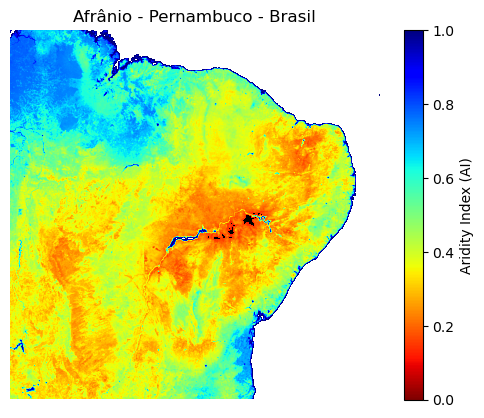

In [30]:
PlotGrafico(_final)